# **Evaluation of Data to predict if a user would subscribe to a term deposit (y/n)**

# Import Libraries

In [10]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import matplotlib.pyplot as plt

# Load Data

In [11]:
df = pd.read_csv('bank-additional-full.csv', delimiter=';')

# Preprocess

In [12]:
numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m', 'nr.employed']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                   'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode categorical features
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Prepare features and target
X = df.drop('y', axis=1)
y = le.fit_transform(df['y'])

# Make the Neural Network


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class BankClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize Model

In [14]:
model = BankClassifier(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop

In [15]:
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [2/10], Loss: 0.1307
Epoch [4/10], Loss: 0.1507
Epoch [6/10], Loss: 0.1717
Epoch [8/10], Loss: 0.1806
Epoch [10/10], Loss: 0.1788


# Evaluate

In [16]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'\nTest Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9142


# Use SHAP to determine the Data Point which contributed most value.

PermutationExplainer explainer: 8239it [03:58, 32.91it/s]                          


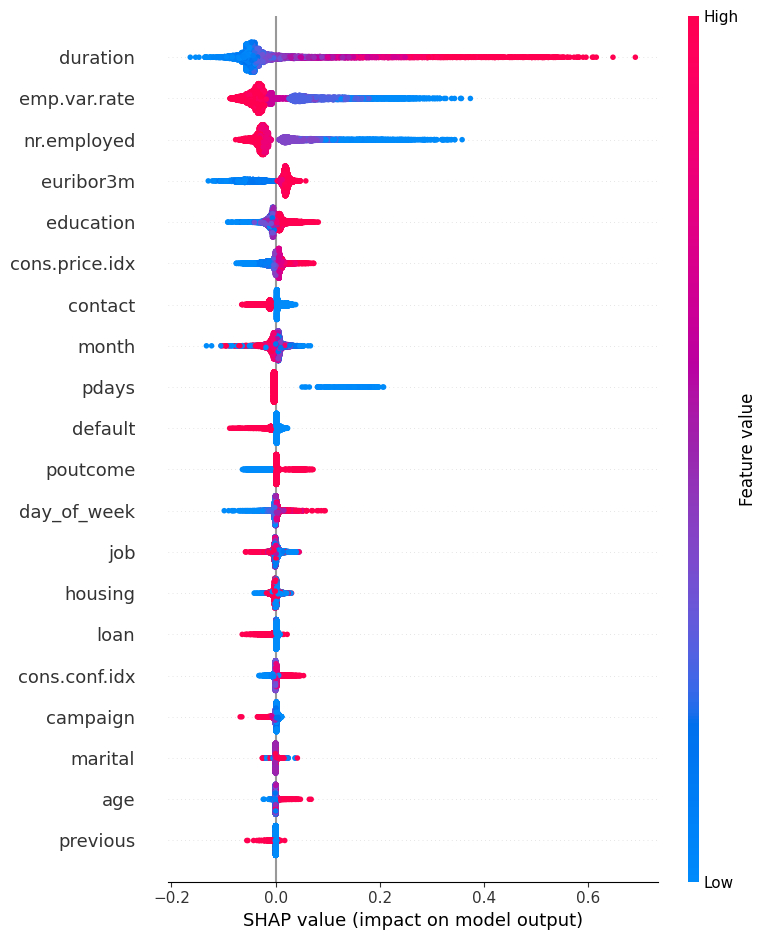

In [17]:
# Convert PyTorch model to a SHAP-compatible function
def model_wrapper(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_tensor)  # Get raw model outputs
        probs = torch.softmax(logits, dim=1)[:, 1].numpy()  # Convert to probabilities for class 1
    return probs

# Create SHAP Explainer
explainer = shap.Explainer(model_wrapper, X_train.numpy())

# Compute SHAP values
shap_values = explainer(X_test.numpy())

# Global Feature Importance Plot
shap.summary_plot(shap_values, X_test.numpy(), feature_names=X.columns)

# Local SHAP Analysis for Observation #4 and #20
obs_4 = X_test[3:4].numpy()  # Row index 3 (4th observation)
obs_20 = X_test[19:20].numpy()  # Row index 19 (20th observation)

# Use the shap_values directly without expected_value
shap.force_plot(shap_values[3], feature_names=X.columns)
shap.force_plot(shap_values[19], feature_names=X.columns)

plt.show()